<a href="https://colab.research.google.com/github/nakampany/DeepLearning2022/blob/main/09_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN
## 時系列分類問題でRNNを体験してみる

- 以下のページで公開されているECG（心電図）の波形データセットECG5000をRNNで学習し，分類してみよう．
  - http://timeseriesclassification.com/description.php?Dataset=ECG5000
    1. 上記URLからデータセットをDLしする．
    2. このjupyter notebookと同じフォルダにdataフォルダを作成する．
    3. DLしたzipを展開し，展開後のファイル一式をdata配下に置く．


- このデータセットはECGの計測値140時点分と，その系列に対する分類（1～5）で1データとなっており，全体で5000データが含まれている．

### データセットのロード
- ロード周りは本質的ではないのであまり気にしなくて良い．
- 自身が分析する際には適宜変更すると良い．

In [ ]:
from scipy.io import arff
import numpy as np

# 2022/11/29時点で上記URLからデーセットをDLした結果，訓練用と検証用に分かれていた．
# 関数化しておいて，ファイルパスを入力するとarff形式のファイルから，X,yを抽出するようにしてある．
def load_data_from_arff(file):
    dataset, meta = arff.loadarff(file)  # arffデータのロード
    ds = np.asarray(dataset.tolist(), dtype=np.float32)   # numpy型に変換
    x_dataset = ds[:, :140]    # 入力時系列X
    y_dataset = np.asarray(ds[:,-1].tolist(), dtype=np.int8)-1  # 出力ラベルy
    
    return x_dataset, y_dataset

# 関数を使って訓練用，検証用データセットをロードする．
X_train, y_train = load_data_from_arff('./data/ECG5000_TRAIN.arff')
X_test, y_test = load_data_from_arff('./data/ECG5000_TEST.arff')

# 書式の確認
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

FileNotFoundError: ignored

### データの可視化
- Xとyのペアを可視化して様子を見てみる．
- AIが素晴らしいとは言え，基礎的な可視化をおろそかにすることはあってはならない（自戒を込めて）．

[3 3 3 3 3 3 3 3 4 4]


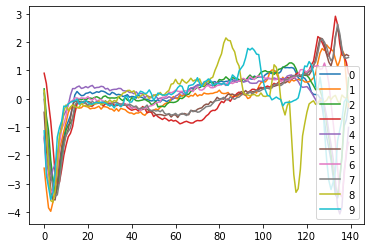

In [ ]:
# 後ろ10件を可視化してみる．
import matplotlib.pyplot as plt

N = 10
print(y_train[-N:])
obj = plt.plot(X_train[-N:].T)
plt.legend(obj, [str(n) for n in range(N)])

- 可視化して様子が確認できる通り，後ろ二件（8,9）のデータの波形の挙動がおかしいことが確認できる．ラベルも他と異なっている．

### RNNを用いた分類（データセット準備）
- 準備していたデータを用いてPytorchで利用できるようなDataset型とDataLoader型インスタンスを準備する．
- 一点注意事項として，入力の書式は[?, seq, feat]となる点がある．
  - ?はバッチサイズ（今回は100）
  - seqはシーケンスのサイズ（今回は140）→これが資料で言う$x_t$のtが0から139までを意味する．
  - featは特徴量数→今回はECGが1チャネルなので1
    - 3チャネルで計測した場合3波形を同時に入力する感じ（$x_t$が多次元になる）．

In [ ]:
from torch.utils.data import DataLoader, Dataset

# ただただデータを渡すだけの中継役のDataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# バッチサイズ
batch_size = 100

# 訓練用DatasetとDataLoaderを作成する．
# X_trainのshapeが[?, 140]なので，[?, 140, 1]に変形している．
ds_train = MyDataset(torch.tensor(X_train[:, :, np.newaxis]), torch.tensor(y_train, dtype=torch.long))
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)

# テスト用DatasetとDataLoaderを作成する．
ds_test = MyDataset(torch.tensor(X_test[:, :, np.newaxis]), torch.tensor(y_test, dtype=torch.long))
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

### RNNを用いた分類（モデル準備）

In [ ]:
from torch import nn
class ecg2type(nn.Module):
    def __init__(self,input_size,hidden_size, batch_size, layer=1, output_size=5):
        super(ecg2type,self).__init__()
        # ハイパーパラメータ系
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.layer = layer
        self.output_size = output_size
        # レイヤ系 (Input -> RNN -> Linear(Output))
        self.rnn0 = nn.RNN(input_size, hidden_size, layer, batch_first=True)
        self.lc = nn.Linear(hidden_size, self.output_size)
        
    def forward(self,x):
        # h0=self.init_hidden(self.layer, self.batch_size, self.hidden_size, x.device)
        # x,h0=self.rnn0(x, h0)
        # 上の二行を用いるor下の一行を用いる．どちらでも良い（初期化方法の違い）．
        # RNNの入力は[?, seq, feat]となり，バッチサイズとseqをまとめて入力すると，
        # seqを順次入力して状態hと出力yを出力していく．
        # 状態hは時刻tごとに出力されるので以下のxは[?, seq, hidden_size]が，
        # hは[1, ?, hidden_size]が格納される（hは最終的な状態）．
        x, h0 = self.rnn0(x, None)
        # そこで最終状態hを出力層に入力することで，これをもとに最終的な出力クラスを1つ決定する．
        #res = self.lc(h0.view(self.batch_size,1,self.hidden_size))
        res = self.lc(h0.view(self.batch_size, self.hidden_size))
        return res.view(self.batch_size, self.output_size)
    
    def init_hidden(self, layer, batch_size, hidden_size, device):
        return torch.randn(layer, batch_size, hidden_size).to(device)

### RNNを用いた分類（訓練）

In [ ]:
from sklearn.metrics import classification_report,accuracy_score

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = ecg2type(1,50,batch_size,1)  # モデルのインスタンス化
model = model.to(device)             # GPUに移動
criterion = nn.CrossEntropyLoss()    # 分類問題なのでCELoss
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)  # 最適化手法
n_epochs = 200                       # 訓練エポック数

for epoch in range(1,n_epochs+1):
    model.train()
    for seq_n, y_n in train_dataloader:   # 訓練用ループ
        seq_n, y_n = seq_n.to(device), y_n.to(device)
        optimizer.zero_grad()
        y_p=model(seq_n)
        loss=criterion(y_p,y_n)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        preds, ys=[], []
        for b_n,y_n in test_dataloader:   # 検証用ループ
            b_n, y_n = b_n.to(device), y_n.to(device)
            model.eval()
            y_p=model(b_n)
            _, predicted = torch.max(y_p, 1)
            preds+=list(predicted.to("cpu").detach().numpy())
            ys+=list(y_n.to("cpu").detach().numpy())
        print(epoch)
        print(classification_report(np.array(ys), np.array(preds), target_names=["1","2","3","4","5"]))

1
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2627
           2       0.11      0.02      0.03      1590
           3       0.03      0.86      0.05        86
           4       0.10      0.01      0.01       175
           5       0.02      0.23      0.04        22

    accuracy                           0.02      4500
   macro avg       0.05      0.22      0.03      4500
weighted avg       0.04      0.02      0.01      4500

2
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      2627
           2       0.11      0.02      0.03      1590
           3       0.03      0.86      0.05        86
           4       0.10      0.01      0.01       175
           5       0.02      0.23      0.04        22

    accuracy                           0.02      4500
   macro avg       0.05      0.22      0.03      4500
weighted avg       0.04      0.02      0.01      4500

3
              pr

18
              precision    recall  f1-score   support

           1       0.01      0.00      0.00      2627
           2       0.11      0.02      0.03      1590
           3       0.03      0.85      0.05        86
           4       0.09      0.01      0.01       175
           5       0.02      0.18      0.04        22

    accuracy                           0.03      4500
   macro avg       0.05      0.21      0.03      4500
weighted avg       0.05      0.03      0.01      4500

19
              precision    recall  f1-score   support

           1       0.01      0.01      0.01      2627
           2       0.11      0.02      0.03      1590
           3       0.03      0.85      0.05        86
           4       0.09      0.01      0.01       175
           5       0.02      0.18      0.04        22

    accuracy                           0.03      4500
   macro avg       0.05      0.21      0.03      4500
weighted avg       0.05      0.03      0.02      4500

20
             

35
              precision    recall  f1-score   support

           1       0.09      0.05      0.06      2627
           2       0.10      0.02      0.03      1590
           3       0.03      0.83      0.05        86
           4       0.00      0.00      0.00       175
           5       0.02      0.09      0.03        22

    accuracy                           0.05      4500
   macro avg       0.05      0.20      0.03      4500
weighted avg       0.09      0.05      0.05      4500

36
              precision    recall  f1-score   support

           1       0.09      0.05      0.07      2627
           2       0.10      0.02      0.03      1590
           3       0.03      0.83      0.05        86
           4       0.00      0.00      0.00       175
           5       0.02      0.09      0.03        22

    accuracy                           0.05      4500
   macro avg       0.05      0.20      0.04      4500
weighted avg       0.09      0.05      0.05      4500

37
             

52
              precision    recall  f1-score   support

           1       0.17      0.11      0.13      2627
           2       0.10      0.02      0.03      1590
           3       0.02      0.73      0.05        86
           4       0.00      0.00      0.00       175
           5       0.04      0.09      0.06        22

    accuracy                           0.08      4500
   macro avg       0.07      0.19      0.05      4500
weighted avg       0.14      0.08      0.09      4500

53
              precision    recall  f1-score   support

           1       0.18      0.11      0.14      2627
           2       0.10      0.02      0.03      1590
           3       0.02      0.73      0.05        86
           4       0.00      0.00      0.00       175
           5       0.05      0.09      0.06        22

    accuracy                           0.09      4500
   macro avg       0.07      0.19      0.06      4500
weighted avg       0.14      0.09      0.09      4500

54
             

69
              precision    recall  f1-score   support

           1       0.27      0.20      0.23      2627
           2       0.13      0.01      0.02      1590
           3       0.02      0.64      0.04        86
           4       0.00      0.00      0.00       175
           5       0.07      0.05      0.05        22

    accuracy                           0.13      4500
   macro avg       0.10      0.18      0.07      4500
weighted avg       0.20      0.13      0.14      4500

70
              precision    recall  f1-score   support

           1       0.27      0.20      0.23      2627
           2       0.12      0.01      0.02      1590
           3       0.02      0.64      0.04        86
           4       0.00      0.00      0.00       175
           5       0.07      0.05      0.05        22

    accuracy                           0.13      4500
   macro avg       0.10      0.18      0.07      4500
weighted avg       0.20      0.13      0.14      4500

71
             

86
              precision    recall  f1-score   support

           1       0.33      0.28      0.30      2627
           2       0.08      0.00      0.00      1590
           3       0.02      0.60      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.18      4500
   macro avg       0.09      0.18      0.07      4500
weighted avg       0.22      0.18      0.18      4500

87
              precision    recall  f1-score   support

           1       0.33      0.28      0.31      2627
           2       0.09      0.00      0.00      1590
           3       0.02      0.58      0.04        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.18      4500
   macro avg       0.09      0.17      0.07      4500
weighted avg       0.22      0.18      0.18      4500

88
             

103
              precision    recall  f1-score   support

           1       0.38      0.36      0.37      2627
           2       0.40      0.00      0.00      1590
           3       0.02      0.55      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.22      4500
   macro avg       0.16      0.18      0.08      4500
weighted avg       0.36      0.22      0.22      4500

104
              precision    recall  f1-score   support

           1       0.38      0.37      0.37      2627
           2       0.67      0.00      0.00      1590
           3       0.02      0.55      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.22      4500
   macro avg       0.21      0.18      0.08      4500
weighted avg       0.46      0.22      0.22      4500

105
          

C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


110
              precision    recall  f1-score   support

           1       0.40      0.40      0.40      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.24      4500
   macro avg       0.08      0.18      0.09      4500
weighted avg       0.23      0.24      0.23      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


111
              precision    recall  f1-score   support

           1       0.40      0.40      0.40      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.24      4500
   macro avg       0.08      0.18      0.09      4500
weighted avg       0.23      0.24      0.23      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


112
              precision    recall  f1-score   support

           1       0.40      0.41      0.40      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.25      4500
   macro avg       0.09      0.18      0.09      4500
weighted avg       0.23      0.25      0.24      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


113
              precision    recall  f1-score   support

           1       0.40      0.41      0.41      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.25      4500
   macro avg       0.09      0.18      0.09      4500
weighted avg       0.24      0.25      0.24      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


114
              precision    recall  f1-score   support

           1       0.41      0.41      0.41      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.25      4500
   macro avg       0.09      0.19      0.09      4500
weighted avg       0.24      0.25      0.24      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


115
              precision    recall  f1-score   support

           1       0.41      0.42      0.41      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.25      4500
   macro avg       0.09      0.19      0.09      4500
weighted avg       0.24      0.25      0.24      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


116
              precision    recall  f1-score   support

           1       0.41      0.43      0.42      2627
           2       0.00      0.00      0.00      1590
           3       0.02      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.26      4500
   macro avg       0.09      0.19      0.09      4500
weighted avg       0.24      0.26      0.25      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


117
              precision    recall  f1-score   support

           1       0.41      0.43      0.42      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.26      4500
   macro avg       0.09      0.19      0.09      4500
weighted avg       0.24      0.26      0.25      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


118
              precision    recall  f1-score   support

           1       0.42      0.44      0.43      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.26      4500
   macro avg       0.09      0.19      0.09      4500
weighted avg       0.24      0.26      0.25      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


119
              precision    recall  f1-score   support

           1       0.42      0.44      0.43      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.27      4500
   macro avg       0.09      0.19      0.10      4500
weighted avg       0.25      0.27      0.25      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


120
              precision    recall  f1-score   support

           1       0.42      0.45      0.43      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.27      4500
   macro avg       0.09      0.19      0.10      4500
weighted avg       0.25      0.27      0.25      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


121
              precision    recall  f1-score   support

           1       0.43      0.45      0.44      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.27      4500
   macro avg       0.09      0.19      0.10      4500
weighted avg       0.25      0.27      0.26      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


122
              precision    recall  f1-score   support

           1       0.43      0.46      0.44      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.28      4500
   macro avg       0.09      0.19      0.10      4500
weighted avg       0.25      0.28      0.26      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


123
              precision    recall  f1-score   support

           1       0.43      0.47      0.45      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.28      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.25      0.28      0.26      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


124
              precision    recall  f1-score   support

           1       0.43      0.47      0.45      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.28      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.25      0.28      0.26      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


125
              precision    recall  f1-score   support

           1       0.44      0.48      0.46      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.29      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.29      0.27      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


126
              precision    recall  f1-score   support

           1       0.44      0.48      0.46      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.29      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.29      0.27      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


127
              precision    recall  f1-score   support

           1       0.44      0.48      0.46      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.51      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.29      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.29      0.27      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


128
              precision    recall  f1-score   support

           1       0.44      0.49      0.46      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.50      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.29      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.29      0.27      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


129
              precision    recall  f1-score   support

           1       0.44      0.49      0.47      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.50      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.30      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.30      0.27      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


130
              precision    recall  f1-score   support

           1       0.45      0.50      0.47      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.50      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.30      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.30      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


131
              precision    recall  f1-score   support

           1       0.45      0.50      0.47      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.49      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.30      4500
   macro avg       0.09      0.20      0.10      4500
weighted avg       0.26      0.30      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


132
              precision    recall  f1-score   support

           1       0.45      0.51      0.48      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.49      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.30      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.26      0.30      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


133
              precision    recall  f1-score   support

           1       0.45      0.51      0.48      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.49      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.31      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.26      0.31      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


134
              precision    recall  f1-score   support

           1       0.45      0.51      0.48      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.47      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.31      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.26      0.31      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135
              precision    recall  f1-score   support

           1       0.46      0.52      0.49      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.47      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.31      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.27      0.31      0.28      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


136
              precision    recall  f1-score   support

           1       0.46      0.53      0.49      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.44      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.32      4500
   macro avg       0.10      0.19      0.11      4500
weighted avg       0.27      0.32      0.29      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


137
              precision    recall  f1-score   support

           1       0.46      0.53      0.49      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.44      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.32      4500
   macro avg       0.10      0.19      0.11      4500
weighted avg       0.27      0.32      0.29      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


138
              precision    recall  f1-score   support

           1       0.46      0.54      0.50      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.44      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.32      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.27      0.32      0.29      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


139
              precision    recall  f1-score   support

           1       0.47      0.54      0.50      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.44      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.33      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.27      0.33      0.29      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


140
              precision    recall  f1-score   support

           1       0.47      0.55      0.50      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.33      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.27      0.33      0.30      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


141
              precision    recall  f1-score   support

           1       0.47      0.56      0.51      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.33      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.27      0.33      0.30      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


142
              precision    recall  f1-score   support

           1       0.47      0.56      0.51      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.34      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.28      0.34      0.30      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


143
              precision    recall  f1-score   support

           1       0.47      0.57      0.52      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.34      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.28      0.34      0.30      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


144
              precision    recall  f1-score   support

           1       0.48      0.57      0.52      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.34      4500
   macro avg       0.10      0.20      0.11      4500
weighted avg       0.28      0.34      0.30      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


145
              precision    recall  f1-score   support

           1       0.48      0.58      0.52      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.34      4500
   macro avg       0.10      0.20      0.12      4500
weighted avg       0.28      0.34      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


146
              precision    recall  f1-score   support

           1       0.48      0.58      0.53      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.35      4500
   macro avg       0.10      0.20      0.12      4500
weighted avg       0.28      0.35      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


147
              precision    recall  f1-score   support

           1       0.48      0.58      0.53      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.35      4500
   macro avg       0.10      0.20      0.12      4500
weighted avg       0.28      0.35      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


148
              precision    recall  f1-score   support

           1       0.48      0.59      0.53      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.35      4500
   macro avg       0.10      0.20      0.12      4500
weighted avg       0.28      0.35      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


149
              precision    recall  f1-score   support

           1       0.48      0.59      0.53      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.35      4500
   macro avg       0.10      0.20      0.12      4500
weighted avg       0.28      0.35      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


150
              precision    recall  f1-score   support

           1       0.49      0.60      0.54      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.05        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.36      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.28      0.36      0.31      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


151
              precision    recall  f1-score   support

           1       0.49      0.60      0.54      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.36      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.29      0.36      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152
              precision    recall  f1-score   support

           1       0.49      0.61      0.54      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.36      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.29      0.36      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


153
              precision    recall  f1-score   support

           1       0.49      0.61      0.54      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.36      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.29      0.36      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


154
              precision    recall  f1-score   support

           1       0.49      0.61      0.55      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.37      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.29      0.37      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


155
              precision    recall  f1-score   support

           1       0.49      0.62      0.55      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.37      4500
   macro avg       0.10      0.21      0.12      4500
weighted avg       0.29      0.37      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


156
              precision    recall  f1-score   support

           1       0.50      0.62      0.55      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.37      4500
   macro avg       0.11      0.21      0.12      4500
weighted avg       0.29      0.37      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


157
              precision    recall  f1-score   support

           1       0.50      0.63      0.55      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.43      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.37      4500
   macro avg       0.11      0.21      0.12      4500
weighted avg       0.29      0.37      0.32      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


158
              precision    recall  f1-score   support

           1       0.50      0.63      0.56      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.38      4500
   macro avg       0.11      0.21      0.12      4500
weighted avg       0.29      0.38      0.33      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


159
              precision    recall  f1-score   support

           1       0.50      0.64      0.56      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.38      4500
   macro avg       0.11      0.21      0.12      4500
weighted avg       0.29      0.38      0.33      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


160
              precision    recall  f1-score   support

           1       0.50      0.65      0.57      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.38      4500
   macro avg       0.11      0.21      0.13      4500
weighted avg       0.29      0.38      0.33      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


161
              precision    recall  f1-score   support

           1       0.50      0.65      0.57      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.39      4500
   macro avg       0.11      0.21      0.13      4500
weighted avg       0.30      0.39      0.33      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


162
              precision    recall  f1-score   support

           1       0.51      0.65      0.57      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.39      4500
   macro avg       0.11      0.21      0.13      4500
weighted avg       0.30      0.39      0.33      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


163
              precision    recall  f1-score   support

           1       0.51      0.66      0.57      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.39      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.39      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


164
              precision    recall  f1-score   support

           1       0.51      0.66      0.57      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.39      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.39      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


165
              precision    recall  f1-score   support

           1       0.51      0.67      0.58      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.40      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.40      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


166
              precision    recall  f1-score   support

           1       0.51      0.67      0.58      2627
           2       0.00      0.00      0.00      1590
           3       0.03      0.42      0.06        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.40      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.40      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


167
              precision    recall  f1-score   support

           1       0.51      0.68      0.58      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.40      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.40      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


168
              precision    recall  f1-score   support

           1       0.52      0.68      0.59      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.41      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.41      0.34      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


169
              precision    recall  f1-score   support

           1       0.52      0.69      0.59      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.41      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.41      0.35      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


170
              precision    recall  f1-score   support

           1       0.52      0.69      0.59      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.41      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.41      0.35      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


171
              precision    recall  f1-score   support

           1       0.52      0.69      0.59      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.41      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.41      0.35      4500

172


C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t

              precision    recall  f1-score   support

           1       0.52      0.70      0.59      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.42      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.41      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.41      0.35      4500

173
              precision    recall  f1-score   support

           1       0.52      0.70      0.60      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.42      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.30      0.42      0.35      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


174
              precision    recall  f1-score   support

           1       0.52      0.71      0.60      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.42      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.31      0.42      0.35      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


175
              precision    recall  f1-score   support

           1       0.52      0.71      0.60      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.42      4500
   macro avg       0.11      0.22      0.13      4500
weighted avg       0.31      0.42      0.35      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


176
              precision    recall  f1-score   support

           1       0.52      0.72      0.61      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.43      4500
   macro avg       0.11      0.22      0.14      4500
weighted avg       0.31      0.43      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


177
              precision    recall  f1-score   support

           1       0.53      0.72      0.61      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.43      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.43      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


178
              precision    recall  f1-score   support

           1       0.53      0.73      0.61      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.43      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.43      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


179
              precision    recall  f1-score   support

           1       0.53      0.73      0.61      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.07        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.43      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.43      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


180
              precision    recall  f1-score   support

           1       0.53      0.73      0.62      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.44      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.44      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


181
              precision    recall  f1-score   support

           1       0.53      0.74      0.62      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.44      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.44      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


182
              precision    recall  f1-score   support

           1       0.53      0.74      0.62      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.44      4500
   macro avg       0.11      0.23      0.14      4500
weighted avg       0.31      0.44      0.36      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


183
              precision    recall  f1-score   support

           1       0.53      0.75      0.62      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.45      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.31      0.45      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


184
              precision    recall  f1-score   support

           1       0.53      0.75      0.63      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.45      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.31      0.45      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


185
              precision    recall  f1-score   support

           1       0.54      0.76      0.63      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.45      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.31      0.45      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


186
              precision    recall  f1-score   support

           1       0.54      0.76      0.63      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.41      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.45      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.31      0.45      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


187
              precision    recall  f1-score   support

           1       0.54      0.77      0.63      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.40      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.46      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.32      0.46      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


188
              precision    recall  f1-score   support

           1       0.54      0.77      0.63      2627
           2       0.00      0.00      0.00      1590
           3       0.04      0.38      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.46      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.32      0.46      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


189
              precision    recall  f1-score   support

           1       0.54      0.78      0.64      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.38      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.46      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.32      0.46      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


190
              precision    recall  f1-score   support

           1       0.54      0.78      0.64      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.38      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.46      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.32      0.46      0.37      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


191
              precision    recall  f1-score   support

           1       0.54      0.78      0.64      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.38      0.08        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.46      4500
   macro avg       0.12      0.23      0.14      4500
weighted avg       0.32      0.46      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


192
              precision    recall  f1-score   support

           1       0.54      0.79      0.64      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.38      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.47      4500
   macro avg       0.12      0.23      0.15      4500
weighted avg       0.32      0.47      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


193
              precision    recall  f1-score   support

           1       0.54      0.79      0.65      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.38      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.47      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.47      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


194
              precision    recall  f1-score   support

           1       0.55      0.80      0.65      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.47      4500
   macro avg       0.12      0.23      0.15      4500
weighted avg       0.32      0.47      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


195
              precision    recall  f1-score   support

           1       0.55      0.80      0.65      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.47      4500
   macro avg       0.12      0.23      0.15      4500
weighted avg       0.32      0.47      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


196
              precision    recall  f1-score   support

           1       0.55      0.81      0.65      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.48      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.48      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


197
              precision    recall  f1-score   support

           1       0.55      0.81      0.65      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.48      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.48      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


198
              precision    recall  f1-score   support

           1       0.55      0.81      0.66      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.48      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.48      0.38      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


199
              precision    recall  f1-score   support

           1       0.55      0.82      0.66      2627
           2       0.00      0.00      0.00      1590
           3       0.05      0.37      0.09        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.48      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.48      0.39      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


200
              precision    recall  f1-score   support

           1       0.55      0.82      0.66      2627
           2       0.00      0.00      0.00      1590
           3       0.06      0.37      0.10        86
           4       0.00      0.00      0.00       175
           5       0.00      0.00      0.00        22

    accuracy                           0.49      4500
   macro avg       0.12      0.24      0.15      4500
weighted avg       0.32      0.49      0.39      4500



C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\t-hase\.conda\envs\torch-kondo\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 参考URL
- ECG5000の分類問題に関する参考文献 (英語)
  - https://nato16.medium.com/classify-the-imbalanced-time-series-data-with-rnn-8b51ad9222bc
  - ちなみに，この文献ではF値90％くらい出てるけど，私のソースではF値49％となっている．
  - これは文献では訓練ーテストを割り直しているけど，私の場合割り直していないため，訓練データが500件と圧倒的に少ないからである．
- RNNを用いた時系列予測に関する参考文献 (日本語)
  - https://qiita.com/ku_a_i/items/0ea4b93d767ce7c83145